In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind

# Set Seaborn Theme
sns.set_theme(
    style="whitegrid",  # Options: "darkgrid", "white", "ticks"
    palette="muted",  # Change to "deep", "pastel", "Set2", etc.
    font_scale=1.2,  # Increases text size for readability
)

# Set Matplotlib defaults
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),  # Default figure size
        "axes.titlesize": 14,  # Title font size
        "axes.labelsize": 12,  # Label font size
        "xtick.labelsize": 10,  # X-axis tick font size
        "ytick.labelsize": 10,  # Y-axis tick font size
        "legend.fontsize": 10,  # Legend font size
        "grid.alpha": 0.3,  # Light grid lines
        "axes.edgecolor": "black",  # Darker axis edges
    }
)

# 1. INTRODUCTION

The fast-food company's marketing unit designed and conducted an A/B test to 
determine the performance of three promotions on a new item. The intent was to 
see which promotion generated the most level of sales revenue.

The trial was conducted across a number of locations in randomly selected 
markets across four weeks. Sales revenue at a weekly rate was tracked as the 
primary basis for comparison.

Being a data analyst, the aim of this analysis is to compare the outcome of 
the experiment, determine which promotion yielded the highest sales revenue, 
and provide data-driven recommendations to the marketing team regarding the 
best campaign.

## 1.1. Success Metric
Since the A/B test aims to evaluate which promotion has the greatest impact on 
the sales revenue of the new product, the revenue will be used as the 
primary metric. This allows us to determine which promotion generates the 
higher sales.


### 1.1.1 Hypothesis

To compare the effectiveness of the three promotions, the following hypotheses 
were formulated:

Promotion 1 vs. Promotion 2

- H₀: The average revenue of Promotion 1 is equal to the average revenue of Promotion 2
- H₁: The average revenue of Promotion 1 is not equal to the average revenue of Promotion 2

Promotion 1 vs. Promotion 3

- H₀: The average revenue of Promotion 1 is equal to the average revenue of Promotion 3
- H₁: The average revenue of Promotion 1 is not equal to the average revenue of Promotion 3

Promotion 2 vs. Promotion 3


- H₀: The average revenue of Promotion 2 is equal to the average revenue of Promotion 3
- H₁: The average revenue of Promotion 2 is not equal to the average revenue of Promotion 3

# 2. EXPLORATORY DATA ANALYSIS (EDA)

The dataset was sourced from Kaggle, where additional information is provided. 
[Dataset Link](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test?resource=download)

In [31]:
data = pd.read_csv(
    r"C:\Users\diana\OneDrive\Ambiente de Trabalho\A-B Testing Marketing Campaign\WA_Marketing-Campaign.csv"
)

In [53]:
data.sample(10)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
142,3,Large,217,5,3,3,86.11
451,9,Medium,806,5,3,4,46.47
39,1,Medium,10,5,2,4,35.16
516,10,Large,913,24,1,1,62.33
56,2,Small,102,8,3,1,61.59
479,10,Large,903,7,3,4,50.05
271,6,Medium,503,2,2,4,37.20
243,5,Medium,411,23,3,4,51.91
3,1,Medium,1,4,3,4,39.25
239,5,Medium,410,11,1,4,54.70


- From the sample generated we can oberve that there are different market sizes definitions and different ages per store.

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


- The data contains 548 entries and 7 columns, and there are no missing values. 

In [34]:
data.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [56]:
occurences_per_promotion = data.groupby("Promotion").size().reset_index(name="Count")
print(occurences_per_promotion)

   Promotion  Count
0          1    172
1          2    188
2          3    188


In [36]:
location_counts_per_promotion = (
    data.groupby("Promotion")["LocationID"]
    .nunique()
    .reset_index(name="UniqueLocationCount")
)
print(location_counts_per_promotion)

   Promotion  UniqueLocationCount
0          1                   43
1          2                   47
2          3                   47


- At the outset, it's important to note that the number of locations and occurrences is equal across the three promotions. 
- This observation should be kept in mind when interpreting the results, as the differences may stem from factors beyond sample size. 
- However, if the locations in this experiment were determined based on where the company has hubs, then we may not have full control over this variability, as I don't have much insight into the experiment's design. Nonetheless, we will proceed with the analysis regardless.



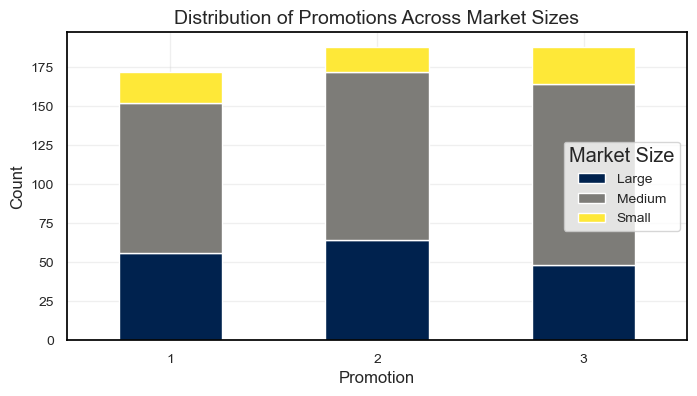

In [37]:
market_size_counts = (
    data.groupby("Promotion")["MarketSize"].value_counts().reset_index(name="Count")
)


market_size_pivot = market_size_counts.pivot(
    index="Promotion", columns="MarketSize", values="Count"
).fillna(0)

market_size_pivot.plot(kind="bar", stacked=True, figsize=(8, 4), colormap="cividis")


plt.xlabel("Promotion")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.title("Distribution of Promotions Across Market Sizes")
plt.legend(title="Market Size")
plt.show()

- When looking at the distribution of market sizes across promotions, we can also observe variability.

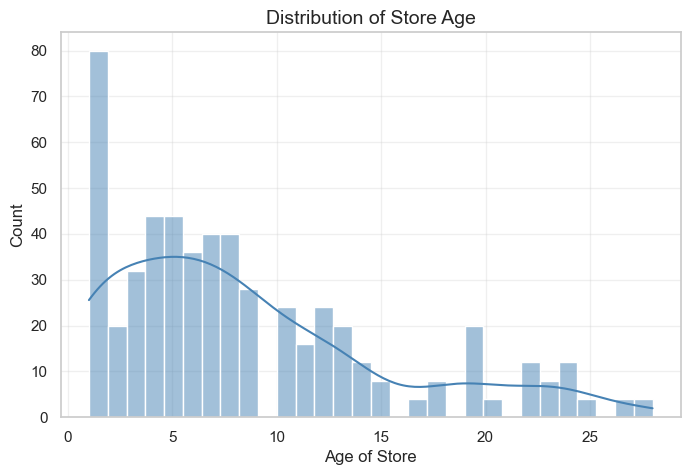

In [38]:
sns.set_theme(style="whitegrid")
sns.histplot(data=data, x="AgeOfStore", kde=True, color="steelblue", bins=30)
plt.xlabel("Age of Store", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Store Age", fontsize=14)

plt.show()

- We also observe that the majority of the stores were opened relatively recently, with an average age of 9 years.

- When designing the experiment, these factors should be taken into account. 
- For instance, newer stores might not have as many regular customers, and market size could be correlated with sales, influencing the results.

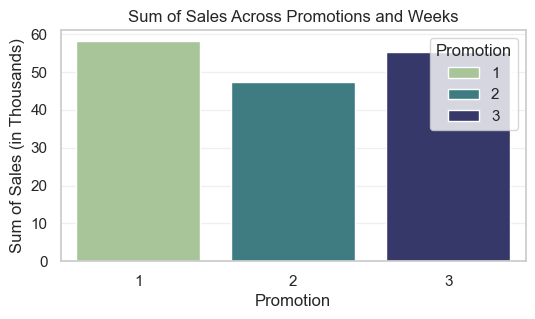

In [62]:
sum_sales = data.groupby("Promotion")["SalesInThousands"].mean().reset_index()
plt.figure(figsize=(6, 3))
sns.barplot(
    data=sum_sales,
    x="Promotion",
    y="SalesInThousands",
    hue="Promotion",
    palette="crest",
)
plt.title("Sum of Sales Across Promotions and Weeks")
plt.xlabel("Promotion")
plt.ylabel("Sum of Sales (in Thousands)")
plt.show()

- From the graph, we can observe differences in revenue across the campaigns over the 4 weeks. 
- While these differences are evident, statistical tests will provide us with the confidence to determine whether these variations are statistically significant.

# 3. STATISCAL TESTING

The T-Test is used to compare the means of two groups and determine if there is 
a statistically significant difference between them. Given that we are analyzing
 the effectiveness of three different promotional campaigns, we will perform 
 multiple Two-Sample T-Tests to compare the average sales between each pair 
 of promotions.

Before conducting the T-test, we verified that the conditions for its 
application are met:

- Each sample consists of more than 30 data points, ensuring the reliability of 
the test.
- According to the Central Limit Theorem, the sample of means will approximate 
a normal distribution.

However, performing multiple tests increases the risk of Type I errors (α), 
which occur when the null hypothesis is incorrectly rejected. 
To account for this, we adjusted the confidence interval to 99%, effectively lowering the 
probability of observing a false positive. 
This results in setting α (the significance level) at 0.01, reducing the likelihood of detecting a 
difference between the promotions when none exists.

For each promotion, we calculated the average sales across all locations. This helps compare how each promotion performed on average across locations.

Aggregating at the location level ensures that you're comparing promotions based on their overall performance at each location.

In [68]:
def perform_ttest(data, promo1, promo2, alpha=0.01):
    """
    Perform T-test between two promotions after aggregating sales by location.

    :param data: DataFrame containing sales data
    :param promo1: First promotion to compare
    :param promo2: Second promotion to compare
    :param alpha: Significance level (default is 0.01 for 99% confidence)
    """
    # Aggregate the sales data by location and promotion
    promo1_data = (
        data[data["Promotion"] == promo1]
        .groupby("LocationID")["SalesInThousands"]
        .mean()
    )
    promo2_data = (
        data[data["Promotion"] == promo2]
        .groupby("LocationID")["SalesInThousands"]
        .mean()
    )

    # Perform T-test between the two groups (Welch's t-test)
    t_stat, p_value = stats.ttest_ind(promo1_data, promo2_data, equal_var=False)

    print(
        f"T-statistic between Promotion {promo1} and Promotion {promo2}: {t_stat:.4f}"
    )
    print(f"P-value between Promotion {promo1} and Promotion {promo2}: {p_value:.4f}")

    # Compare p-value to the alpha
    if p_value < alpha:
        print(
            f"Reject the null hypothesis: Significant difference between Promotion {promo1} and Promotion {promo2}"
        )
    else:
        print(
            f"Fail to reject the null hypothesis: No significant difference between Promotion {promo1} and Promotion {promo2}"
        )

In [69]:
perform_ttest(data, promo1=1, promo2=2, alpha=0.01)

T-statistic between Promotion 1 and Promotion 2: 3.3321
P-value between Promotion 1 and Promotion 2: 0.0013
Reject the null hypothesis: Significant difference between Promotion 1 and Promotion 2


In [70]:
perform_ttest(data, promo1=1, promo2=3, alpha=0.01)

T-statistic between Promotion 1 and Promotion 3: 0.7999
P-value between Promotion 1 and Promotion 3: 0.4259
Fail to reject the null hypothesis: No significant difference between Promotion 1 and Promotion 3


In [71]:
perform_ttest(data, promo1=2, promo2=3, alpha=0.01)

T-statistic between Promotion 2 and Promotion 3: -2.5180
P-value between Promotion 2 and Promotion 3: 0.0136
Fail to reject the null hypothesis: No significant difference between Promotion 2 and Promotion 3


 - When performing multiple comparisons, applying the Bonferroni correction is recommended as it helps control the overall Type I error rate. 
 - This adjustment becomes more impactful when a larger number of tests are being conducted. 
 - In this case, if the p-values are consistently small, it may suggest that the differences between the promotions are indeed significant, meaning the Bonferroni correction does not drastically alter the outcome.

# 5. Results Interpretation

From the results, we observe that :

- Promotion 1 generated significantly (p-value = 0.000) higher revenue compared to Promotion 2, 
with total sales of 9993.03 and 8897.93, respectively, which is approximately 
10.97% higher. 

- Promotion 2 underperformed significantly (p-value = 0.000) in revenue compared to Promotion 3
(8897.93 vs. 10408.52), with Promotion 3 performing 16.98% better. 

- The difference in revenue between Promotion 1 and Promotion 3 
(9993.03 vs. 10408.52) was not statistically significant (p-value=0.1206).


# 6. Recomendtation & Next Steps

- Based on the analysis, it is suggested to discontinue 
Promotion 2 in favor of either Promotion 1 or Promotion 3, as these two have shown better performance. 
- However, to make a more informed decision between the two, a follow-up experiment should be conducted where Promotion 1 and Promotion 3 are directly compared to each other.


## 6.1. Limitations


There are a few limitations to this A/B test:
- Firstly, the experiment was conducted over a 4-week period, which may not fully capture the long-term effects of these promotional campaigns. 
- Extending the testing period could provide a more comprehensive view of the campaigns' performance. 
- Additionally, confounding variables may have influenced the results, and proper research should have been conducted to identify and control for these variables prior to running the experiment.



# 7. RESOURCES


- (1) [T.Test Video](https://www.youtube.com/watch?v=pTmLQvMM-1M)
- (2) [More on Multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem)
- (3) [Confounding variables](https://www.sciencedirect.com/science/article/pii/S0085253815529748)
- (4) [Confounding variables](https://medium.com/@jhalaksurve/understanding-confounding-variables-a-comprehensive-guide-846b30462b6b)